<a href="https://colab.research.google.com/github/clepigdo/Latihan_STKI2025/blob/main/PipelineKlasifikasi_NB_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install ekphrasis

import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Sklearn Libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report

# NLTK Libraries
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Ekphrasis
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 3.9 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Konfigurasi Ekphrasis
text_processor = TextPreProcessor(
    normalize=['email', 'percent', 'money', 'phone', 'user', 'time', 'date', 'number'],
    annotate={"hashtag","allcaps","elongated","repeated",'emphasis','censored'},
    fix_html=True,
    segmenter="twitter",
    corrector="twitter",
    unpack_hashtags=True,
    unpack_contractions=True,
    spell_correct_elong=False,
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    dicts=[emoticons]
)

# Fungsi-fungsi Cleaning
def bersih_data(text):
    return " ".join(text_processor.pre_process_doc(text))

def remove_space_alzami(text):
    return " ".join(text.split())

def remove_emoji_alzami(text):
    return ' '.join(re.sub("([x#][A-Za-z0-9]+)"," ", text).split())

def remove_tab(text):
    return text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")

def remove_tab2(text):
    return re.sub('\s+',' ',text)

def remove_rt(text):
    return text.replace('RT'," ")

def remove_mention(text):
    return ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())

def remove_incomplete_url(text):
    return text.replace("http://", " ").replace("https://", " ")

def remove_single_char(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)

def change_stripe(text):
    return text.replace('-'," ")

def remove_punctuation(text):
    remove = string.punctuation
    remove = remove.replace("_", "")
    pattern = r"[{}]".format(remove)
    return re.sub(pattern, "", text)

# Stopwords Indonesia
stopword = nltk.corpus.stopwords.words('indonesian')
def remove_stopwords(text):
    return [word for word in text if word not in stopword]

<>:29: SyntaxWarning: invalid escape sequence '\s'
<>:35: SyntaxWarning: invalid escape sequence '\w'
<>:29: SyntaxWarning: invalid escape sequence '\s'
<>:35: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipython-input-3042423372.py:29: SyntaxWarning: invalid escape sequence '\s'
  return re.sub('\s+',' ',text)
/tmp/ipython-input-3042423372.py:35: SyntaxWarning: invalid escape sequence '\w'
  return ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
/usr/local/lib/python3.12/dist-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_1grams.txt
Reading twitter - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_2grams.txt
Reading twitter - 1grams ...


/usr/local/lib/python3.12/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


In [5]:
# Load Data
df = pd.read_csv('drive/MyDrive/Colab Notebooks/Dataset_Sentimen_Emosi.csv')
df = df.drop(['Emosi'], axis=1)

# Proses Cleaning
final_string = []
for text in df['Tweet'].values:
    proc = bersih_data(text)
    proc = remove_rt(proc)
    proc = change_stripe(proc)
    proc = remove_tab(proc)
    proc = remove_tab2(proc)
    proc = remove_incomplete_url(proc)
    proc = remove_single_char(proc)
    proc = remove_punctuation(proc)
    proc = remove_space_alzami(proc)
    final_string.append(proc)

df["cleaned"] = final_string

# Tokenisasi & Stopword Removal
df['tokens'] = df['cleaned'].apply(word_tokenize)
df['final_tokens'] = df['tokens'].apply(remove_stopwords)

# Gabung kembali jadi kalimat siap pakai
df['ReadyText'] = df['final_tokens'].apply(lambda x: ' '.join(x))

# Hapus data kosong jika ada
df = df[df['ReadyText'] != '']
df = df.dropna()

print("Data berhasil dibersihkan!")
df.head()

Data berhasil dibersihkan!


,Tweet,Sentimen,cleaned,tokens,final_tokens,ReadyText
0,"emang lemes bgt ya mulut lu, gue yg mau beli-b...",-1.0,emang lemes bgt ya mulut lu gue yg mau beli be...,"[emang, lemes, bgt, ya, mulut, lu, gue, yg, ma...","[emang, lemes, bgt, ya, mulut, lu, gue, yg, be...",emang lemes bgt ya mulut lu gue yg beli beli o...
1,"Cegah mata rantai Covid-19,mari kita dirumah s...",1.0,cegah mata rantai covid number mari kita dirum...,"[cegah, mata, rantai, covid, number, mari, kit...","[cegah, mata, rantai, covid, number, mari, dir...",cegah mata rantai covid number mari dirumah mi...
2,aku mohon yaAllah semoga wabah covid-19 menghi...,1.0,aku mohon yaallah semoga wabah covid number me...,"[aku, mohon, yaallah, semoga, wabah, covid, nu...","[mohon, yaallah, semoga, wabah, covid, number,...",mohon yaallah semoga wabah covid number menghi...
3,Pemprov Papua Naikkan Status Jadi Tanggap Daru...,1.0,pemprov papua naikkan status jadi tanggap daru...,"[pemprov, papua, naikkan, status, jadi, tangga...","[pemprov, papua, naikkan, status, tanggap, dar...",pemprov papua naikkan status tanggap darurat c...
4,Covid belum nyampe prigen mbak hmm hoax,0.0,covid belum nyampe prigen mbak hmm hoax,"[covid, belum, nyampe, prigen, mbak, hmm, hoax]","[covid, nyampe, prigen, mbak, hmm, hoax]",covid nyampe prigen mbak hmm hoax


In [6]:
X = df['ReadyText']
y = df['Sentimen']

# Split 70:30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f"Jumlah Data Latih: {X_train.shape[0]}")
print(f"Jumlah Data Uji  : {X_test.shape[0]}")

Jumlah Data Latih: 632
Jumlah Data Uji  : 272


In [7]:
# Pipeline Naive Bayes
pipeline_nb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model', MultinomialNB())
])

# Tuning Parameter Sederhana
params_nb = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'model__alpha': [0.1, 1.0]
}

print("Melatih Naive Bayes...")
grid_nb = GridSearchCV(pipeline_nb, params_nb, cv=3, n_jobs=-1)
grid_nb.fit(X_train, y_train)

# Prediksi
y_pred_nb = grid_nb.predict(X_test)
acc_nb_train = accuracy_score(y_train, grid_nb.predict(X_train))
acc_nb_test = accuracy_score(y_test, y_pred_nb)
f1_nb = f1_score(y_test, y_pred_nb, average='weighted')

print(f"NB Train Acc: {acc_nb_train:.3f}")
print(f"NB Test Acc : {acc_nb_test:.3f}")

Melatih Naive Bayes...
NB Train Acc: 0.983
NB Test Acc : 0.603


In [8]:
# Pipeline KNN Fixed
pipeline_knn = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model', KNeighborsClassifier())
])

# Tuning K (Neighbors)
params_knn = {
    'tfidf__ngram_range': [(1, 1)], # Unigram saja biar ringan
    'model__n_neighbors': [3, 5, 7]
}

print("Melatih KNN (Fixed Version)...")
grid_knn = GridSearchCV(pipeline_knn, params_knn, cv=3, n_jobs=-1)
grid_knn.fit(X_train, y_train)

# Prediksi
y_pred_knn = grid_knn.predict(X_test)
acc_knn_train = accuracy_score(y_train, grid_knn.predict(X_train))
acc_knn_test = accuracy_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')

print(f"KNN Train Acc: {acc_knn_train:.3f}")
print(f"KNN Test Acc : {acc_knn_test:.3f}")

Melatih KNN (Fixed Version)...
KNN Train Acc: 0.653
KNN Test Acc : 0.555


In [9]:
# Pipeline SVM
pipeline_svm = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=5, ngram_range=(1, 2))),
    ('model', LinearSVC(random_state=42))
])

print("Melatih SVM...")
pipeline_svm.fit(X_train, y_train)

# Prediksi
y_pred_svm = pipeline_svm.predict(X_test)
acc_svm_train = accuracy_score(y_train, pipeline_svm.predict(X_train))
acc_svm_test = accuracy_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')

print(f"SVM Train Acc: {acc_svm_train:.3f}")
print(f"SVM Test Acc : {acc_svm_test:.3f}")

Melatih SVM...
SVM Train Acc: 0.843
SVM Test Acc : 0.544


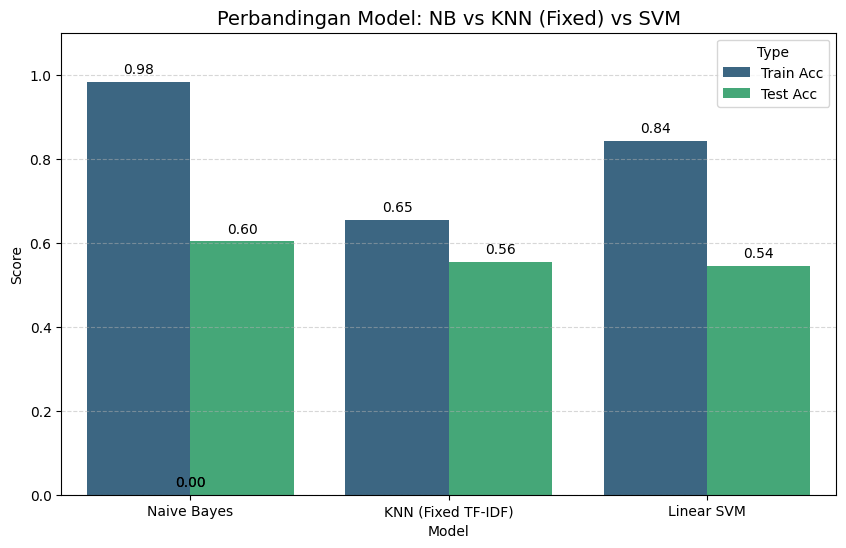


TABEL PERBANDINGAN:


,Model,Train Acc,Test Acc,F1 Score,Overfit Gap
0,Naive Bayes,0.982595,0.602941,0.575365,0.379654
1,KNN (Fixed TF-IDF),0.653481,0.555147,0.542577,0.098334
2,Linear SVM,0.843354,0.544118,0.530084,0.299237


In [10]:
# Buat DataFrame Hasil
results = [
    ['Naive Bayes', acc_nb_train, acc_nb_test, f1_nb],
    ['KNN (Fixed TF-IDF)', acc_knn_train, acc_knn_test, f1_knn],
    ['Linear SVM', acc_svm_train, acc_svm_test, f1_svm]
]

df_res = pd.DataFrame(results, columns=['Model', 'Train Acc', 'Test Acc', 'F1 Score'])
df_res['Overfit Gap'] = df_res['Train Acc'] - df_res['Test Acc']

# Plotting Grafik
df_melt = df_res.melt(id_vars="Model", value_vars=["Train Acc", "Test Acc"], var_name="Type", value_name="Score")

plt.figure(figsize=(10, 6))
sns.barplot(data=df_melt, x="Model", y="Score", hue="Type", palette="viridis")
plt.title("Perbandingan Model: NB vs KNN (Fixed) vs SVM", fontsize=14)
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Tampilkan angka
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.2f}',
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 9), textcoords='offset points')

plt.show()
print("\nTABEL PERBANDINGAN:")
df_res

In [11]:
# Simpan model terbaik (SVM dalam kasus ini)
joblib.dump(pipeline_svm, 'best_model_svm.sav')
print("Model terbaik berhasil disimpan!")

Model terbaik berhasil disimpan!
